In [1]:
#%pylab
#%matplotlib inline
#from astropy.io import fits
#import glob
import wget
#import warnings
#warnings.filterwarnings('ignore')

#plt.style.use(['science', 'nature'])
#plt.rcParams['figure.dpi'] = 250
#np.random.seed(20170615)

ModuleNotFoundError: No module named 'wget'

# Binary System Analysis

## Download Data
First, we use wget to download the data, taking the observation data for Cen X-3 from IXPE as an example. This data has several advantages:
- The data size is manageable.
- It's real and publicly available.

The orbital parameter provided by the GBM epoch-folding monitor (https://gammaray.nsstc.nasa.gov/gbm/science/pulsars/lightcurves/cenx3.html)


| | |
| --------------- | --------------- |
| RA    | 170.3133 deg    |
| Decl  | -60.6233 deg    |
| Orbital Period    | 2.0869953 days    |
| Period Deriv.   | -1.0150E-08 days/day    |
| T half pi  | 2455073.68504 (JED)    |
| axsin(i)    | 39.653 light-sec   |
| Long. of periastron   | 0.00 deg    |
| Eccentricity    | 0.0000    |


In [2]:
# Download the Example Data of IXPE on Cen X-3
!wget -q -nH --no-check-certificate --cut-dirs=5 -r -l0 -c -N -np -R 'index*' -erobots=off --retr-symlinks \
https://heasarc.gsfc.nasa.gov/FTP/ixpe/data/obs/01//01006501/event_l2/
!wget -nH --no-check-certificate --cut-dirs=5 -r -l0 -c -N -np -R 'index*' -erobots=off --retr-symlinks \
https://heasarc.gsfc.nasa.gov/FTP/ixpe/data/obs/01/01006501/hk/ixpe01006501_all_orb_v07.fits.gz

--2023-06-20 11:45:07--  https://heasarc.gsfc.nasa.gov/FTP/ixpe/data/obs/01/01006501/hk/ixpe01006501_all_orb_v07.fits.gz
Resolving heasarc.gsfc.nasa.gov (heasarc.gsfc.nasa.gov)... 129.164.179.23
Connecting to heasarc.gsfc.nasa.gov (heasarc.gsfc.nasa.gov)|129.164.179.23|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘01006501/hk/ixpe01006501_all_orb_v07.fits.gz’ not modified on server. Omitting download.



In [ ]:
!wget -nH --no-check-certificate --cut-dirs=5 -r -l0 -c -N -np -R 'index*' -erobots=off --retr-symlinks \
https://heasarc.gsfc.nasa.gov/FTP/ixpe/data/obs/01/01006501/hk/ixpe01006501_all_orb_v07.fits.gz

In [3]:
!ls 01006501/*

01006501/event_l2:
ixpe01006501_det1_evt2_v15.fits.gz ixpe01006501_det3_evt2_v15.fits.gz
ixpe01006501_det2_evt2_v15.fits.gz

01006501/hk:
ixpe01006501_all_orb_v07.fits.gz


## Barycentric Correction
Next, we use the `barycor` function from the `tatpulsar` package to apply a barycentric correction based on the solar system's center of mass.
Please note that for IXPE data, HEAsoft has a dedicated correction program (`barycorr`).
Here, we are demonstrate that `tatpulsar` package also includes a valid barycentric correction function.

In [4]:
## READ Data
file = glob.glob("./01006501/event_l2/ixpe01006501_det*.fits.gz")
orbit = glob.glob("./01006501/hk/ixpe01006501_all_orb_v07.fits.gz")
time = np.array([])

for evt in file:
    print(evt)
    hdulist = fits.open(evt)
    time = np.append(time, hdulist[1].data.field("TIME"))

./01006501/event_l2/ixpe01006501_det1_evt2_v15.fits.gz
./01006501/event_l2/ixpe01006501_det2_evt2_v15.fits.gz
./01006501/event_l2/ixpe01006501_det3_evt2_v15.fits.gz


In [5]:
from tatpulsar.utils.functions import met2mjd, mjd2met
from tatpulsar.pulse.barycor.barycor import barycor

ra=170.313301 
dec=-60.6233

tdb_mjd = barycor(met2mjd(time, telescope='ixpe'),
                  ra=ra, dec=dec,
                  orbit=orbit[0],
                  accelerate=True)
tdb_met = mjd2met(tdb_mjd, 'ixpe')

Accelerating barycor


## Frequency Search without Binary correction
Next, we perform a period search for the pulsar using the `epoch_folding_search` function in `stingray`. 

What we demonstrate here is that the period found before applying the binary orbit correction is not the intrinsic period of the neutron star. The actual period differs from the modulated period found, due to the binary orbit modulation. 

However, once we apply the binary orbit correction to the photons, the period found is indeed the intrinsic period of the neutron star.

In [6]:
from stingray.pulse.search import epoch_folding_search
period = 4.79660
nbin = 64
df_min = 1e-4
df = 1e-5
frequencies = np.arange(1/period - 1e-3, 1/period + 1e-3, df)

freq, efstat = epoch_folding_search(tdb_met, frequencies, nbin=nbin)

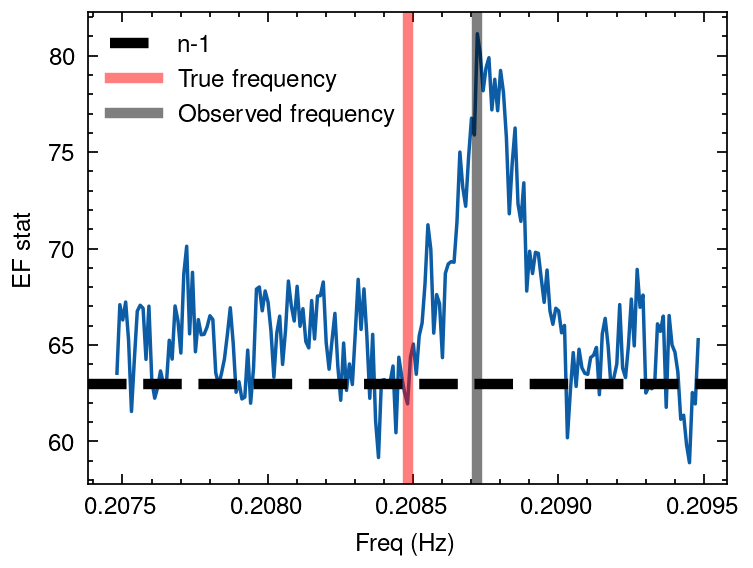

In [7]:
plt.rcParams['figure.dpi'] = 250
plt.figure()
plt.plot(freq, efstat)
plt.axhline(nbin -1, ls='--', lw=3, color='k', label='n-1')
plt.axvline(1/period, lw=3, alpha=0.5, color='r', label='True frequency')
plt.axvline(freq[np.argmax(efstat)], lw=3, alpha=0.5, color='k', label='Observed frequency')
plt.xlabel("Freq (Hz)")
plt.ylabel("EF stat")
plt.legend()

## Binary Correction
Next, we apply a binary orbit correction using two methods. One is the correction under extreme gravitational fields as described in Deeter's paper, and the other is by solving Kepler's equation to calculate the intrinsic emission time of the photons in the binary system.

### Deeter correction 
Correct the photon arrival times to the photon emission time Deeter model.

Reference: `Deeter et al. 1981, ApJ, 247:1003-1012`

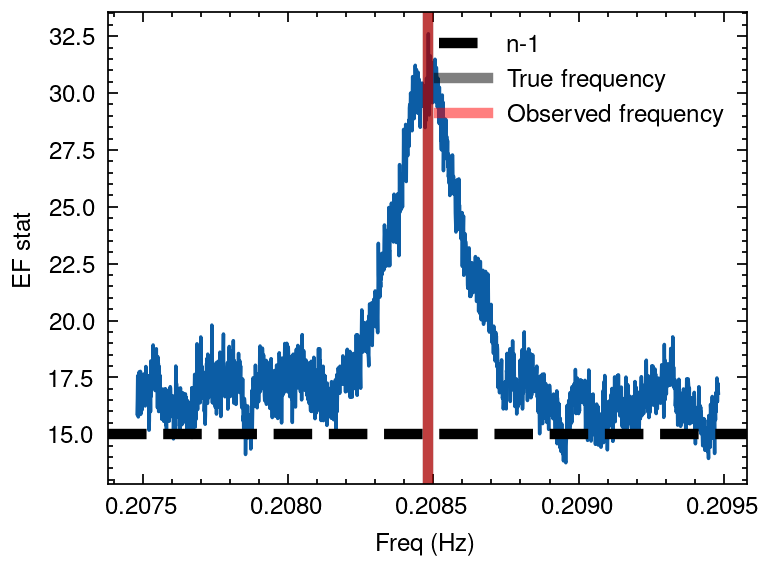

In [8]:
from tatpulsar.pulse.binary import orbit_cor_deeter

#-----------------------------------
Porb = 2.0869953 #day
axsini = 39.653 #light-sec
e = 0.0000
omega = 0.00 - np.pi/2
T_pi2 = 2455073.68504 - 2400000.5 #mjd 
x_mid = 298
y_mid = 306

Tnod = T_pi2 + Porb/2 # mjd
tnod = mjd2met(Tnod, telescope='ixpe') #met

tdb_bicor = orbit_cor_deeter(tdb_met, Porb*86400, axsini, e, omega, tnod)
    
## EF search
period = 4.79660
nbin = 16
df_min = 1e-4
df = 1e-6
frequencies = np.arange(1/period- df_min, 1/period + 1e-3, df)
freq, efstat = epoch_folding_search(tdb_bicor, frequencies, nbin=nbin)

# Plotting
plt.plot(freq, efstat)
plt.axhline(nbin -1, ls='--', lw=3, color='k', label='n-1')
plt.axvline(1/period, lw=3, alpha=0.5, color='black', label='True frequency')
plt.axvline(freq[np.argmax(efstat)], lw=3, alpha=0.5, color='r', label='Observed frequency')
plt.xlabel("Freq (Hz)")
plt.ylabel("EF stat")
plt.legend()

### Solving Kepler equation

In [9]:
from tatpulsar.pulse.binary import orbit_cor_kepler

In [10]:
help(orbit_cor_kepler)

Help on function orbit_cor_kepler in module tatpulsar.pulse.binary:

orbit_cor_kepler(time, Tw, ecc, Porb, omega, axsini, PdotOrb=0, omegadot=0, gamma=0)
    Corrects observed times of photons to their emission times
    based on the Kepler function for a binary system.
    
    Parameters
    ----------
    time: float
        The time of observed photon in MJD
    Tw: float
        The periastron time in MJD
    ecc: float
        Eccentricity
    Porb: float
        Orbital period in second
    PdotOrb: float (optional)
        Second derivative of Orbital period in sec/sec default is 0
    omega: float
        Long. of periastron in radians.
    omegadot: float (optional)
        second derivative of Long. of periastron in rad/sec
    axsini: float
        projection of semi major axis in light-sec
    gamma: float
        0
    
    Returns
    -------
    t_em: float
        The emitting time of photon in binary system in MJD
    
    Example
    -------
    >>> observed_time = n

In [11]:
#-----------------------------------
Porb = 2.0869953 #day
axsini = 39.653 #light-sec
e = 0.0000
omega = 0.00 - np.pi/2
T_pi2 = 2455073.68504 - 2400000.5 #mjd 

T_periastron = T_pi2 + Porb/2 # mjd
t_periastron = mjd2met(Tnod, telescope='ixpe') #met

tdb_bicor_kepler = orbit_cor_kepler(met2mjd(tdb_met, 'ixpe'),
                                    Tw=T_periastron,
                                    ecc=e,
                                    Porb=Porb*86400,
                                    omega=omega,
                                    axsini=axsini)
tdb_bicor_kepler = mjd2met(tdb_bicor_kepler, 'ixpe')

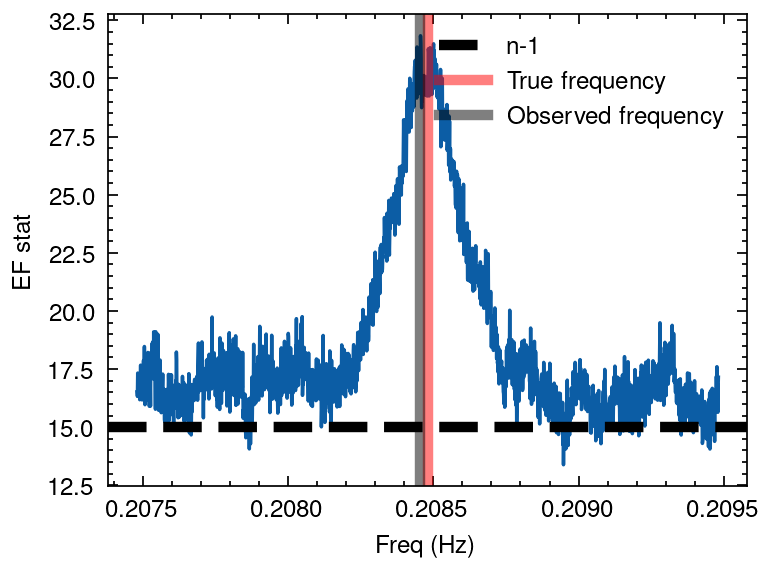

In [12]:
## EF search
period = 4.79660
nbin = 16
df_min = 1e-4
df = 1e-6
frequencies = np.arange(1/period- 1e-3, 1/period + 1e-3, df)
freq, efstat = epoch_folding_search(tdb_bicor_kepler, frequencies, nbin=nbin)

# Plotting
plt.plot(freq, efstat)
plt.axhline(nbin -1, ls='--', lw=3, color='k', label='n-1')
plt.axvline(1/period, lw=3, alpha=0.5, color='r', label='True frequency')
plt.axvline(freq[np.argmax(efstat)], lw=3, alpha=0.5, color='k', label='Observed frequency')
plt.xlabel("Freq (Hz)")
plt.ylabel("EF stat")
plt.legend()

## Determining Binary Ephemeris

For those binary systems with no known binary ephemeris, several strategies can be employed to uncover the binary characteristics of the system. In this section, we'll explore these methods using data from the X-ray binary 4U 1901+03 as an illustrative example on how to derive the binary solution.

### Simulate Binary modulation

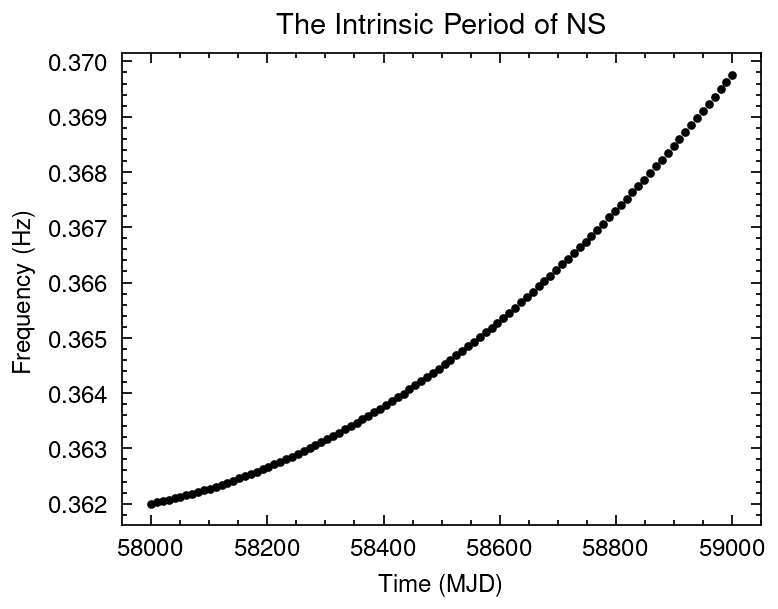

In [13]:
## Simulate the intrinsic frequency evolution of NS
mjd = np.linspace(58000, 59000, 100)
f0_fake = 0.362
f1_fake = 2.5e-11
f2_fake = 1.5e-18
dt = (mjd-mjd.min())*86400
freq_true = f0_fake + f1_fake*dt + (1/2)*f2_fake*dt**2
freq_err = np.ones(freq_true.size)*1e-6 # Hz/s

## Gaussian sampling from the Frequencies data set
freq = np.random.normal(loc=freq_true, scale=freq_err, size=freq_true.size)

plt.title("The Intrinsic Period of NS")
plt.errorbar(mjd, freq, yerr=freq_err, fmt='.', c='k')
plt.xlabel("Time (MJD)")
plt.ylabel("Frequency (Hz)");

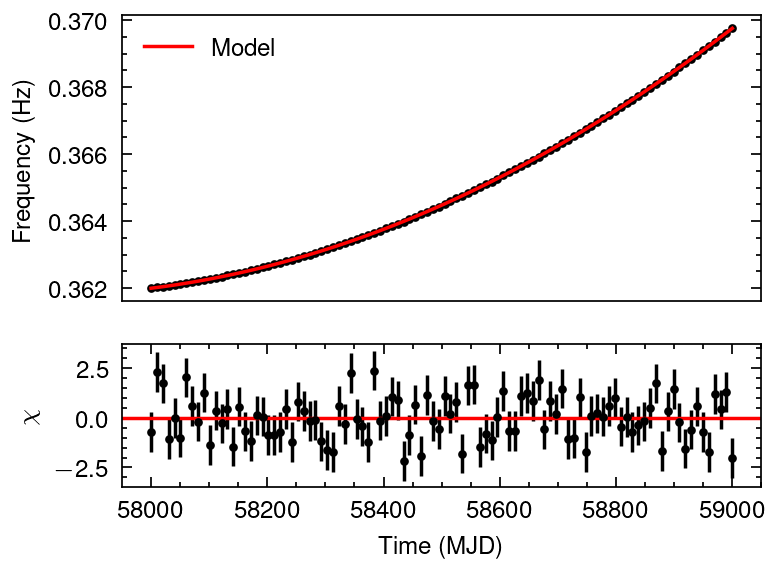

In [14]:
def intrinsic_freq(t, f0, f1, f2):
    t0 = t.min()
    dt = (t - t0)*86400
    f = f0 + f1*dt + 0.5*f2*(dt**2) #+ (1/6)*f3*(dt**3) + (1/24)*f4*(dt**4)
    return f

from scipy.optimize import curve_fit
popt_infrq, pcov_infrq = curve_fit(intrinsic_freq,
                                   mjd, 
                                   freq)

from matplotlib import gridspec
def plot_dataresi(x, y, yerr,
                  model,
                  xlabel="Time (MJD)",
                  ylabel="Freqency (Hz)",
                  legend="Model"):
    fig, (ax1, ax2) = plt.subplots(2,1)
    gs = gridspec.GridSpec(2,1, height_ratios=[2,1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1], sharex=ax1)
    ax1.xaxis.set_ticks_position('none')
    plt.setp(ax1.get_xticklabels(), visible=False)

    ax1.errorbar(x, y, yerr=yerr, fmt='.', c='k')
    ax1.errorbar(x, model, c='r', label=legend)

    ax2.errorbar(x, (y-model)/freq_err,
                 yerr=1, fmt='.', c='k')
    ax2.axhline(y=0, c='r')
    ax2.set_xlabel("Time (MJD)")
    ax1.set_ylabel("Frequency (Hz)")
    ax2.set_ylabel("$\chi$")
    ax1.legend()
plot_dataresi(mjd, freq, freq_err,
              intrinsic_freq(mjd, *popt_infrq),
              xlabel="Time (MJD)", ylabel="Freqency (Hz)")

The fake orbital parameters modulated on the intrinsic frequencies are:

 axsini=2000
 Porb=100 days
 omega=4.71238898038469
 e=0.05
 T_halfpi=58540
 F0=0.362, F1=2.5e-11, F2=1.5e-18


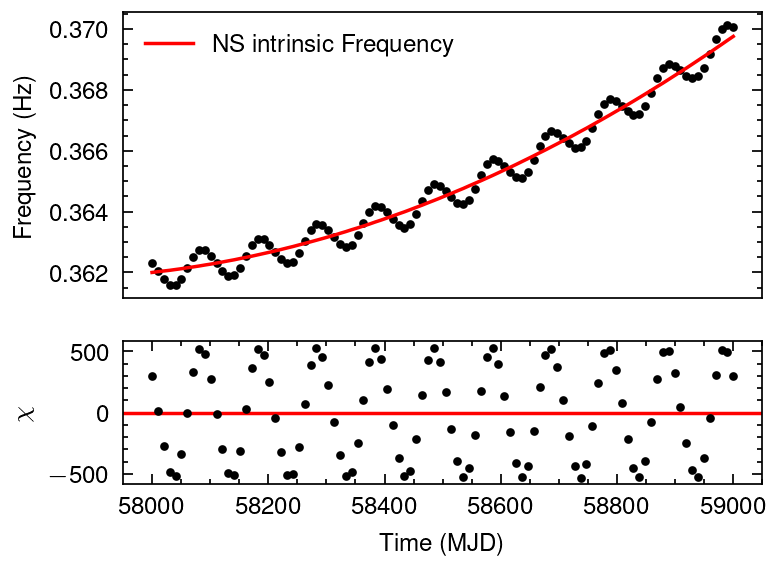

In [15]:
from tatpulsar.pulse.binary import freq_doppler

fake_axsini = 2000
fake_Porb   = 100 #days
fake_omega = 1.5*np.pi
fake_e = 0.05
fake_T_halfpi = 58540

print(f"The fake orbital parameters modulated on the intrinsic frequencies are:\n\n axsini={fake_axsini}\n Porb={fake_Porb} days\n omega={fake_omega}\n"+\
      f" e={fake_e}\n T_halfpi={fake_T_halfpi}\n"+\
      f" F0={f0_fake}, F1={f1_fake}, F2={f2_fake}")

f_dopp = freq_doppler(mjd2met(mjd, 'fermi'),
                      freq[0],
                      axsini=fake_axsini,
                      Porb=fake_Porb*86400,
                      omega=fake_omega,
                      e=fake_e,
                      T_halfpi=fake_T_halfpi)

freq_obs = f_dopp + freq

plot_dataresi(mjd, freq_obs, freq_err,
              freq,
              xlabel="Time (MJD)", ylabel="Freqency (Hz)", legend="NS intrinsic Frequency")

### Least Square Fitting

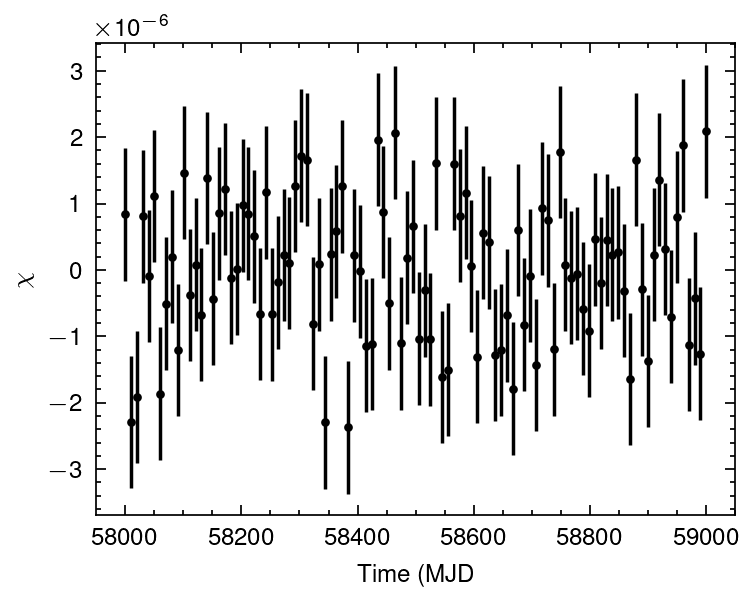

In [16]:
def wrapper_fun(t, 
                f0, f1, f2,
                axsini, Porb, omega, e):
    dt = t-t.min()
    freq = f0 + f1*dt + (1/2)*f2*dt**2
    
    return freq_doppler(t, freq[0], axsini, Porb*86400, omega, e, fake_T_halfpi) + freq
               
popt, pcov = curve_fit(wrapper_fun, mjd2met(mjd, 'fermi'), freq_obs,
                       p0=[f0_fake, f1_fake, f2_fake,
                           fake_axsini, fake_Porb, fake_omega, fake_e])


plt.errorbar(mjd, wrapper_fun(mjd2met(mjd, 'fermi'), *popt) - freq_obs,
             yerr=freq_err, fmt='.', c='k')
plt.ylabel("$\chi$")
plt.xlabel("Time (MJD");

In [17]:
def report_result(popt, pcov):
    perr = np.sqrt(np.diag(pcov))
    par_name = ['F0', 'F1', 'F2', 'axsini', 'Porb', 'Omega', 'Eccentricity']
    for i in range(len(popt)):
        print(f"{par_name[i]}: {popt[i]} +- {perr[i]}")
report_result(popt, pcov)

F0: 0.3619999406313884 +- 3.3209695685669207e-07
F1: 2.4992247763193333e-11 +- 1.775394439010689e-14
F2: 1.5003531933140412e-18 +- 3.9764514319685076e-22
axsini: 2000.395060610975 +- 0.6074379363926161
Porb: 99.99995771438674 +- 7.31267183081882e-05
Omega: 4.709537609067158 +- 0.006136431597904715
Eccentricity: 0.04981853019176014 +- 0.00030180024800663245


### Bayesian Approach (emcee)

The logrithmic Likelihood function is:

$\ln\mathcal{L}(\theta | \mathcal{D}) = -\frac{1}{2} \sum \frac{(f_{\rm{obs}} - f_{\rm{model}})^2}{\sigma^2} $



In [18]:
parameters = ['F0', 'F1', 'F2', 'axsini', 'P_orb', 'omega', 'e']

 # Expect values:  axsini=2000
 # Porb=100 days
 # omega=4.71238898038469
 # e=0.45
 # T_halfpi=58540
 # F0=0.362, F1=2.5e-11, F2=1.5e-18

t = mjd2met(mjd, 'fermi')
data = freq_obs
err = freq_err


def log_likelihood(params, x, y ,yerr):
    f0, f1, f2, axsini, P_orb, omega, e = params

    P_orb = P_orb * 86400
    
    T_halfpi = mjd2met(58540, 'fermi')

    t0 = x.min()
    dt = x - t0

    f_spin = f0 + f1*dt + 0.5*f2*dt**2 
    
    f_dopp = freq_doppler(x, f0, axsini, P_orb, omega, e, fake_T_halfpi)
    model = f_spin + f_dopp

    loglike = -0.5 * np.sum(((y - model)**2/(yerr**2)))
    return loglike

def log_prior(params):
    f0, f1, f2, axsini, P_orb, omega, e = params
    if 0.2 < f0 < 0.563 and 1e-13 < f1 < 6e-11 and 1e-20 < f2 < 6e-18 and 1000 < axsini < 3000 and 50 < P_orb < 150 and np.pi < omega < 3*np.pi and 0 < e < 1:
        return 0.0
    return -np.inf

def log_probability(params, x, y, yerr):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, yerr)


In [19]:
from scipy.optimize import minimize
nll = lambda *args: -log_likelihood(*args)
initial = [f0_fake, f1_fake, f2_fake, fake_axsini, fake_Porb, fake_omega, fake_e]
soln = minimize(nll, initial, args=(t, data, err), method = 'Nelder-Mead')
nwalkers = 32
npars = len(initial)
pos = soln.x+ np.zeros((nwalkers, npars))

pos[:,0] = pos[:,0] + 1e-14 * np.random.randn(nwalkers)
pos[:,1] = pos[:,1] + 1e-14 * np.random.randn(nwalkers)
pos[:,2] = pos[:,2] + 1e-18 * np.random.randn(nwalkers)
pos[:,3] = pos[:,3] + 1e-6 * np.random.randn(nwalkers)
pos[:,4] = pos[:,4] + 1e-14 * np.random.randn(nwalkers)
pos[:,5] = pos[:,5] + 1e-14 * np.random.randn(nwalkers)
pos[:,6] = pos[:,6] + 1e-14 * np.random.randn(nwalkers)

# pos = soln.x + 1e-15 * np.random.randn(nwalkers, 7)
# print(pos[:,1])
nwalkers, ndim = pos.shape

In [20]:
import emcee

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(t, data, err)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 417.70it/s]


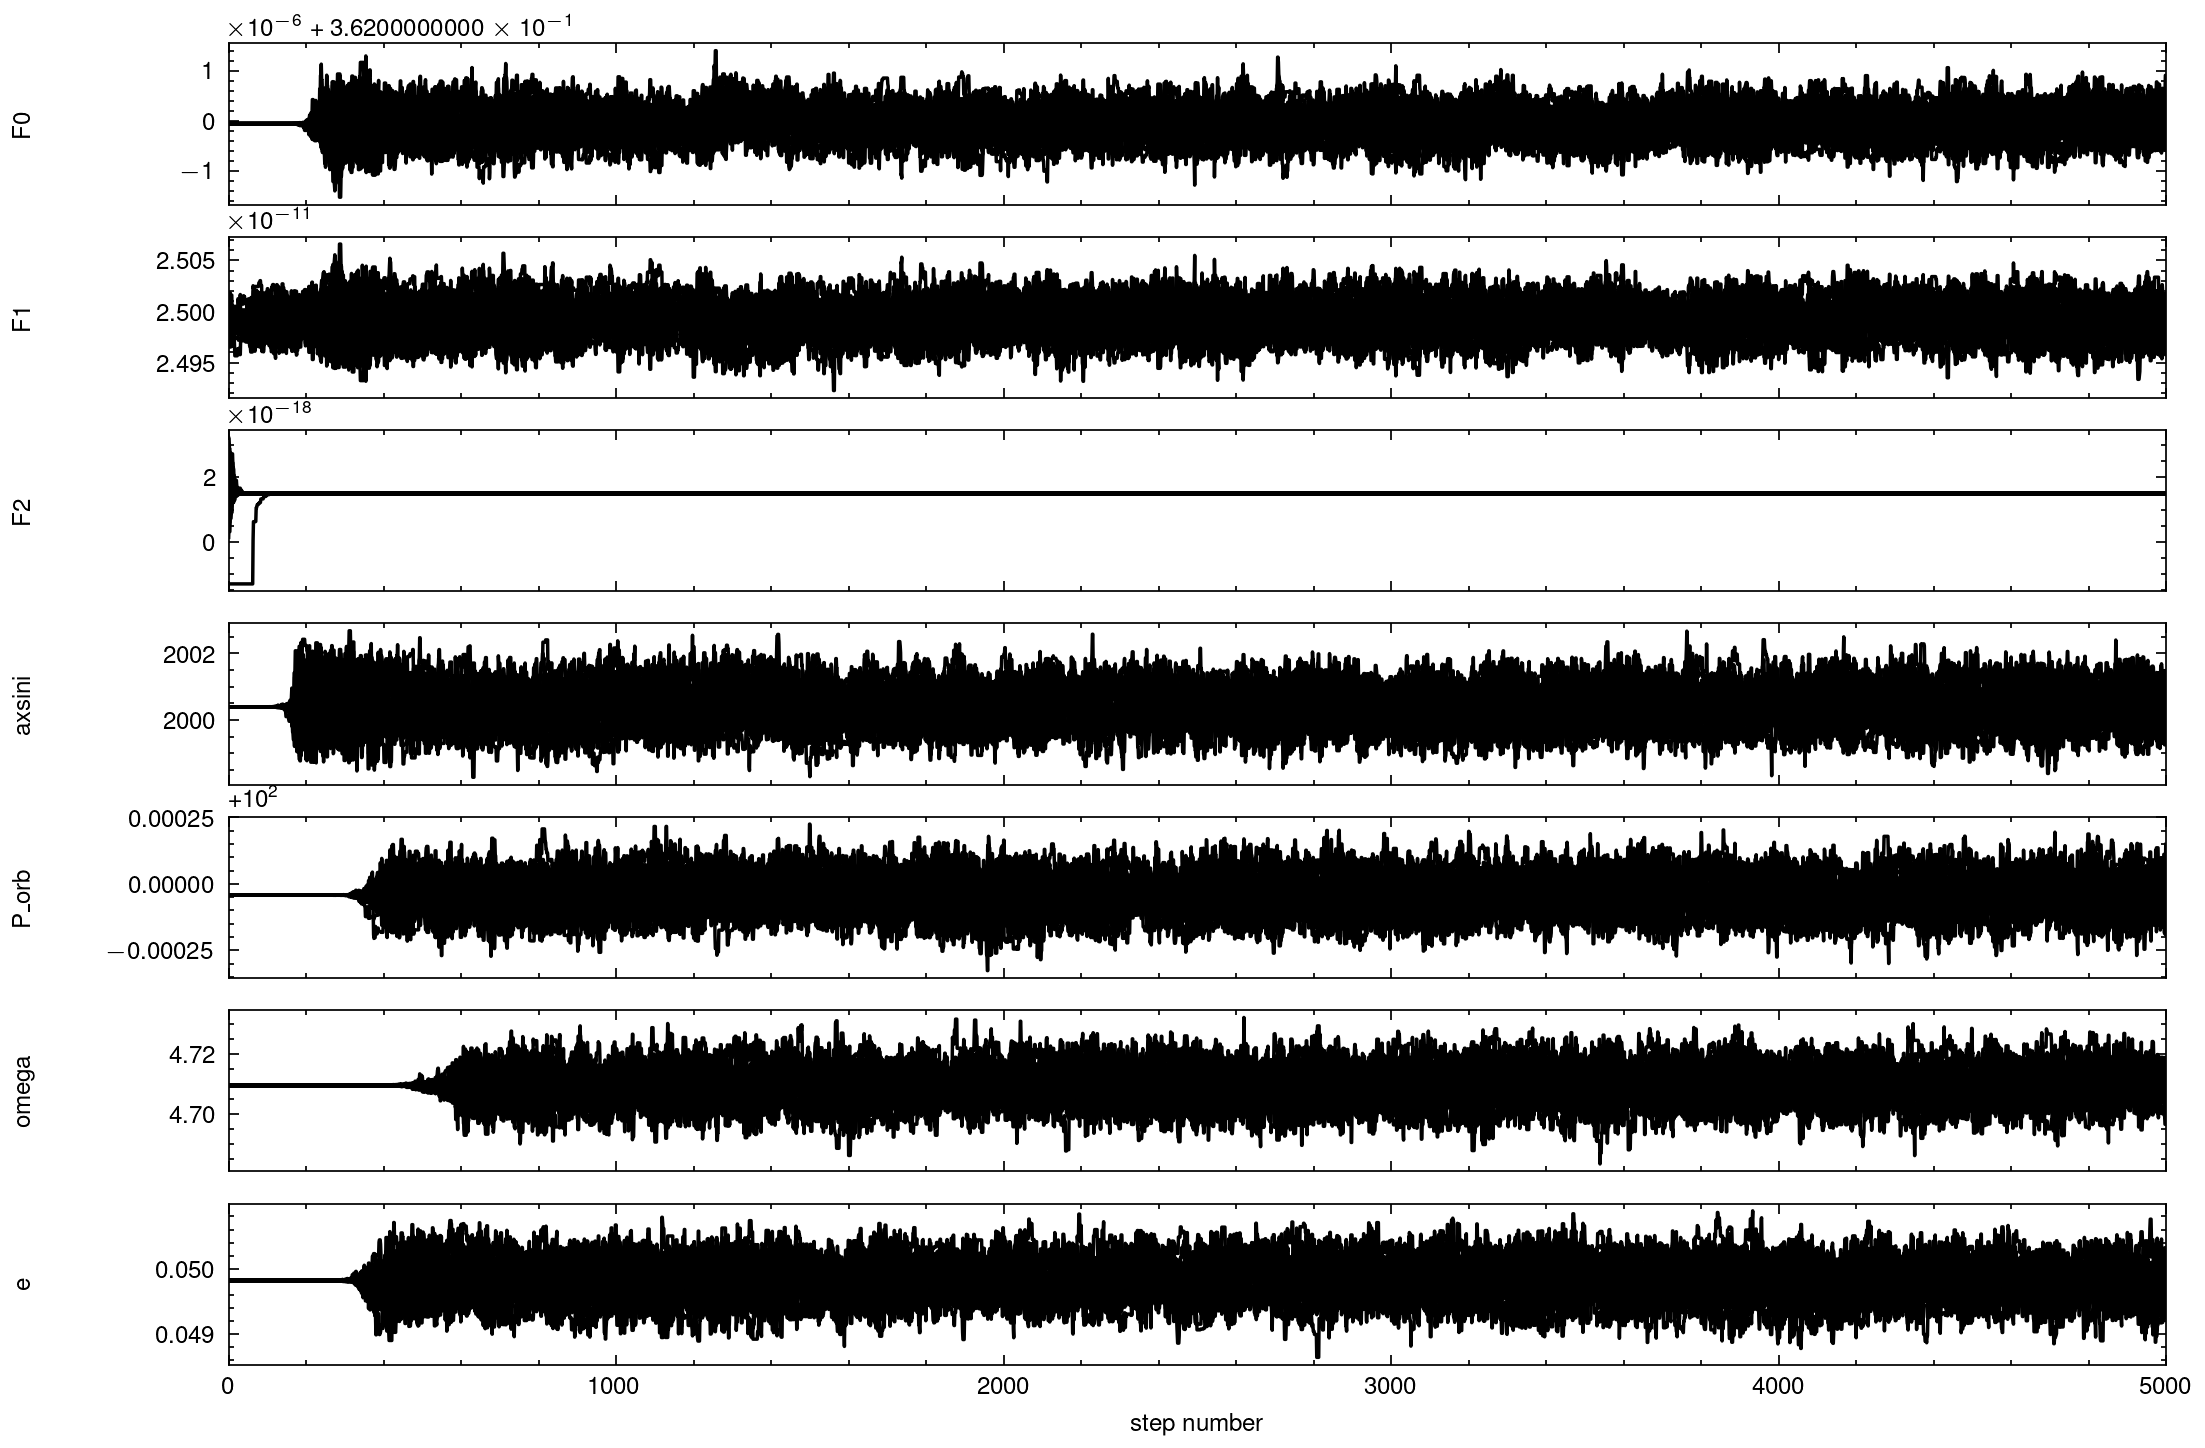

In [21]:
fig, axes = plt.subplots(7, figsize=(10,7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k")
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(parameters[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

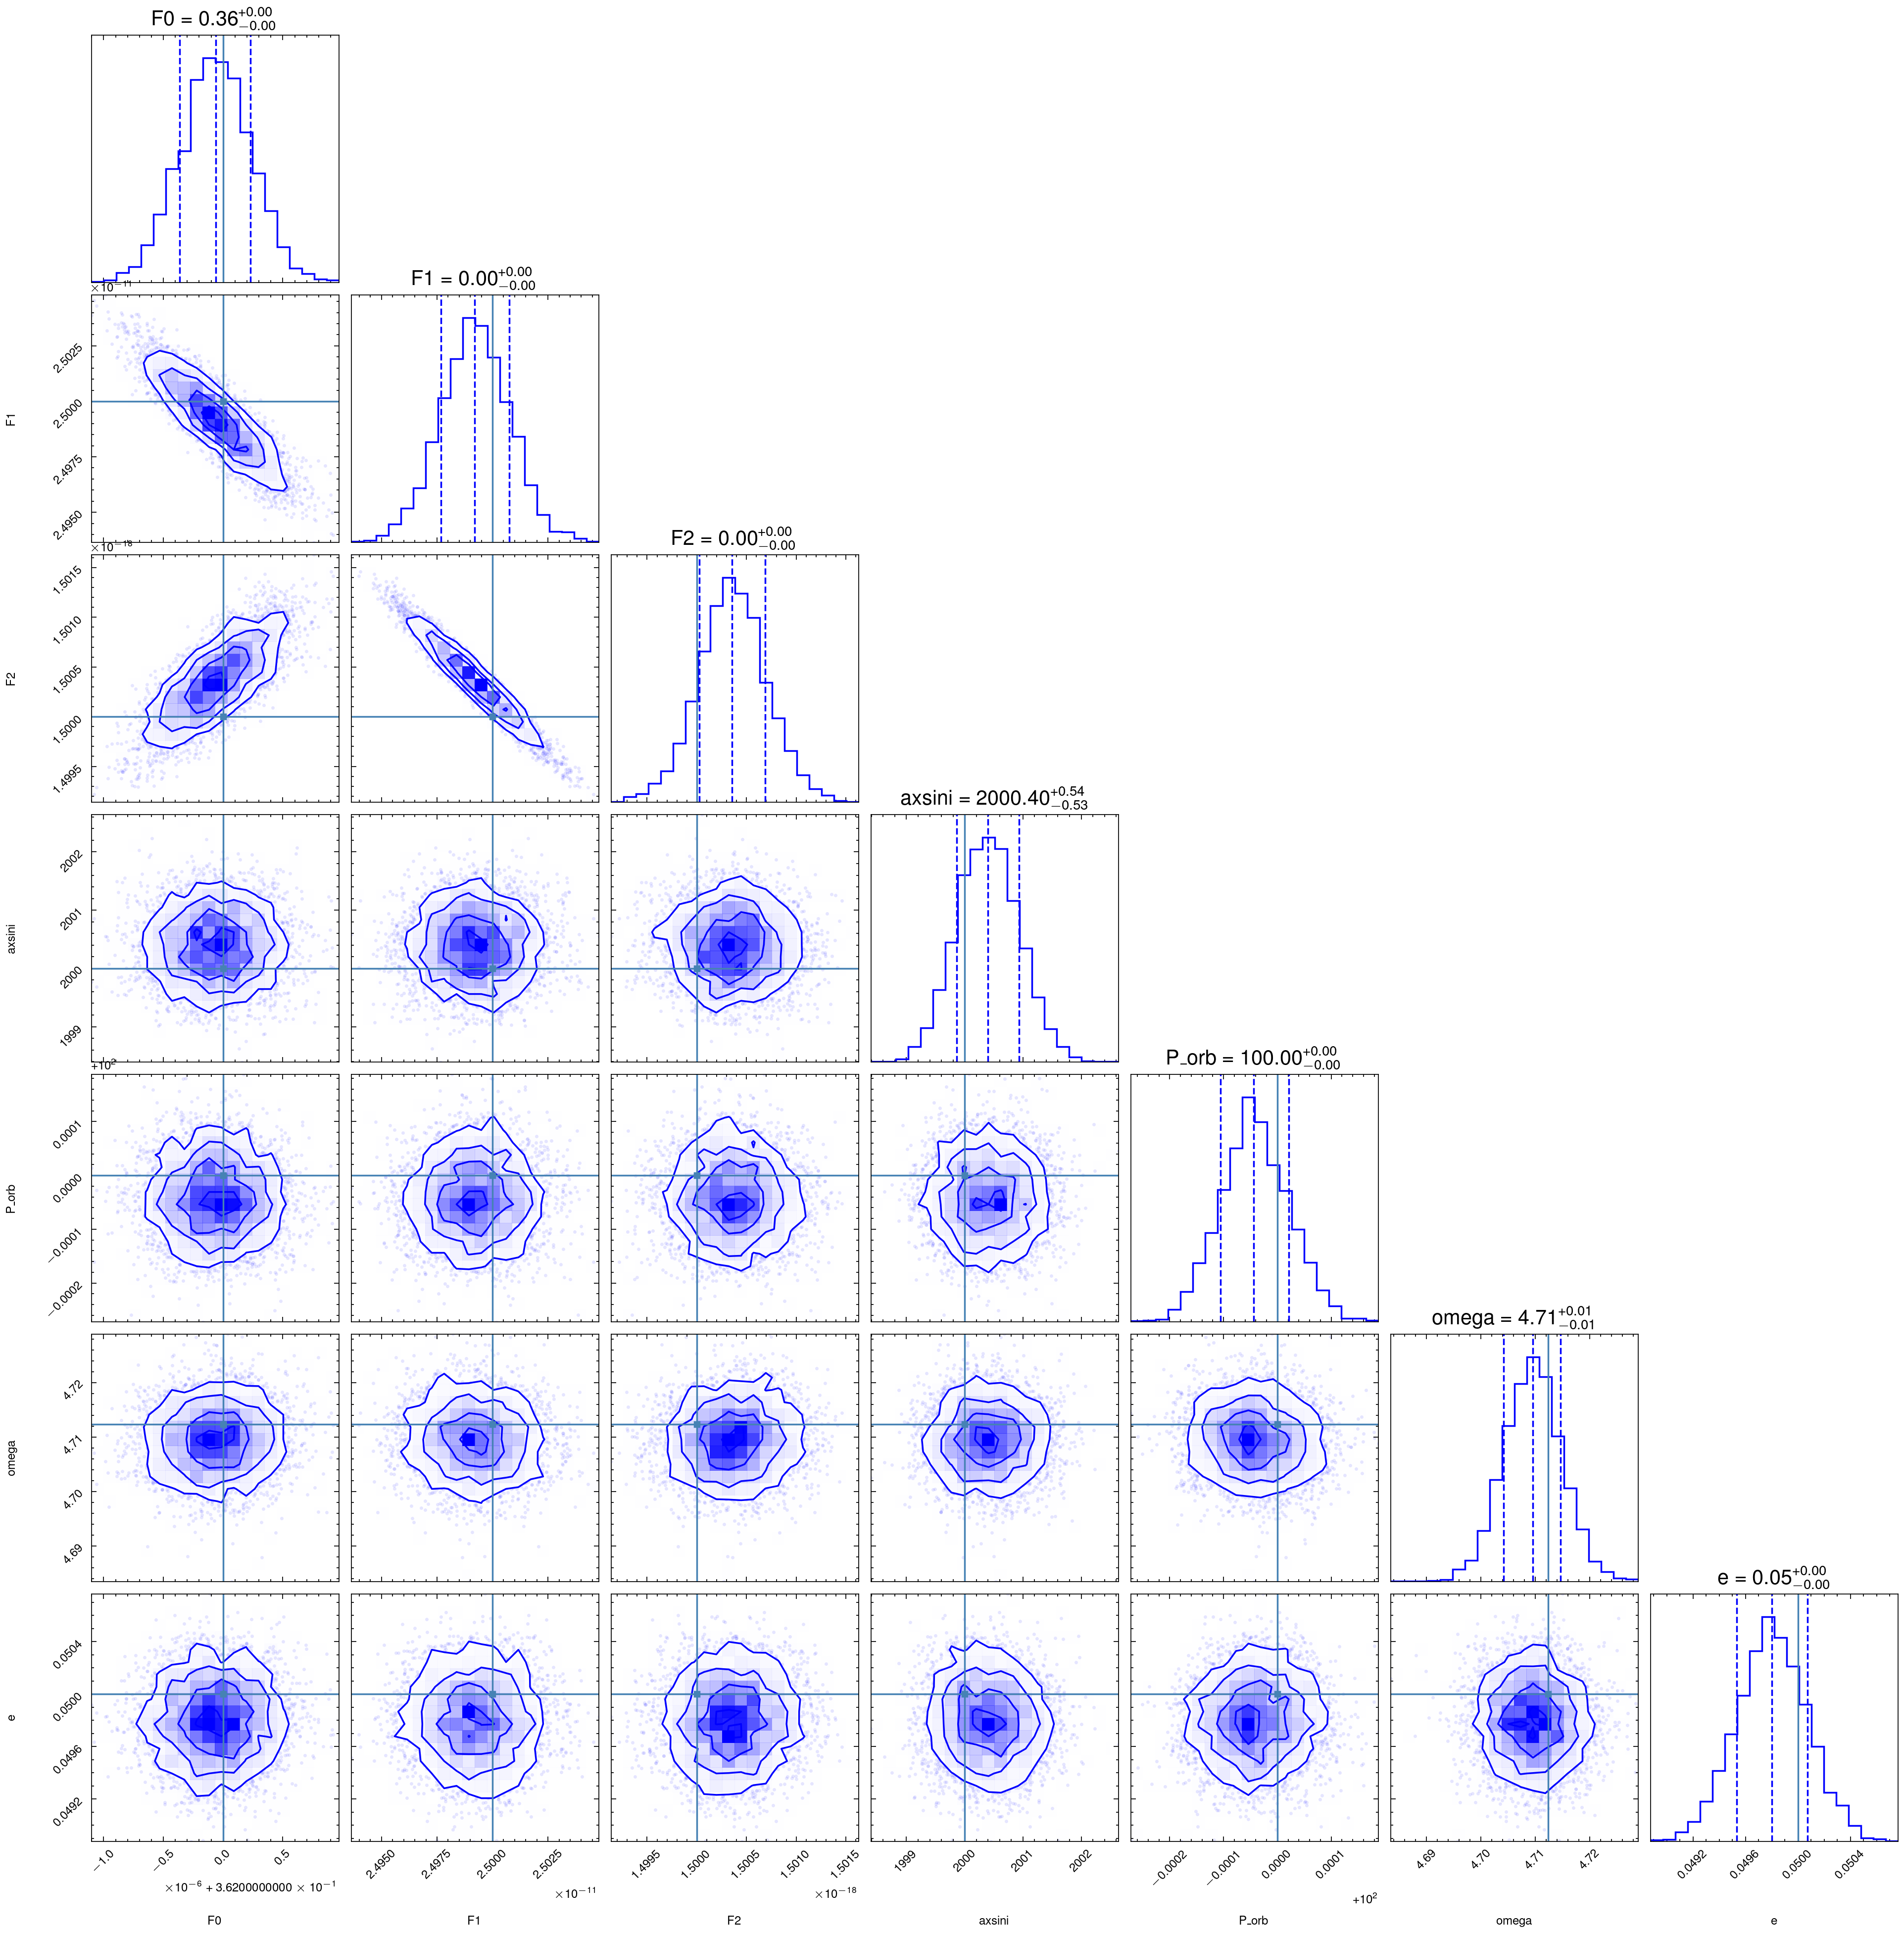

In [22]:
import corner

flat_samples = sampler.get_chain(discard=3000, thin=15, flat=True)
fig = corner.corner(
    flat_samples, labels=parameters, truths=[f0_fake, f1_fake, f2_fake, fake_axsini, fake_Porb, fake_omega, fake_e], color='b',
    quantiles=[0.16, 0.5, 0.84], plot_datapoints=True,show_titles=True, title_kwargs={"fontsize": 12})

### Bayesian Approach (Nested sampling)

In [23]:
def log_likelihood_ns(params):
    f0, f1, f2, axsini, P_orb, omega, e = params
    P_orb = P_orb * 86400
    
    T_halfpi = mjd2met(58540, 'fermi')

    t0 = t.min()

    f_spin = f0 + f1*(t-t0) + 0.5*f2*(t-t0)**2 
    f_dopp = freq_doppler(t, f0, axsini, P_orb, omega, e, fake_T_halfpi)
    
    model = f_spin + f_dopp
    loglike = -0.5* ((data - model)**2/err**2).sum()
    return loglike

def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()

    params[0] = cube[0] * 0.02 + 0.361
    params[1] = cube[1] * 5.0e-11 + 1.0e-11
    params[2] = cube[2] * 5e-18 + 1e-18

    # axsini
    params[3] = cube[3] * 2 + 1999
    
    # P_orb 
    params[4] = cube[4] * 2 + 99

    #omega
    params[5] = cube[5] * 2*np.pi + np.pi
    
    # e
    params[6] = cube[6] 
   
    return params

from ultranest import ReactiveNestedSampler

sampler = ReactiveNestedSampler(parameters, log_likelihood_ns, prior_transform,
    wrapped_params=[False, False, False, False, False, False, False],
)
result = sampler.run(min_num_live_points=200, dKL=np.inf, min_ess=10)

[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e+01  0 [-59.6800..-59.6798]*| it/evals=11223/136630 eff=8.2262% N=200    0    0   0   0      0 
[ultranest] Likelihood function evaluations: 136950
[ultranest]   logZ = -111.1 +- 0.3497
[ultranest] Effective samples strategy satisfied (ESS = 1291.4, need >10)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <inf nat)
[ultranest] Evidency uncertainty strategy wants 214 minimum live points (dlogz from 0.28 to 0.94, need <0.5)
[ultranest]   logZ error budget: single: 0.49 bs:0.35 tail:0.01 total:0.35 required:<0.50
[ultranest] Widening roots to 214 live points (have 200 already) ...
[ultranest] Sampling 14 live points from prior ...


WARNING  (pint.logging                  ): Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.


[ultranest] Explored until L=-6e+01  0 [-59.6673..-59.6638]*| it/evals=12020/161385 eff=3.2554% N=214 
[ultranest] Likelihood function evaluations: 161385
[ultranest]   logZ = -111.1 +- 0.3096
[ultranest] Effective samples strategy satisfied (ESS = 1392.4, need >10)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <inf nat)
[ultranest] Evidency uncertainty strategy wants 212 minimum live points (dlogz from 0.23 to 0.72, need <0.5)
[ultranest]   logZ error budget: single: 0.48 bs:0.31 tail:0.01 total:0.31 required:<0.50
[ultranest] done iterating.


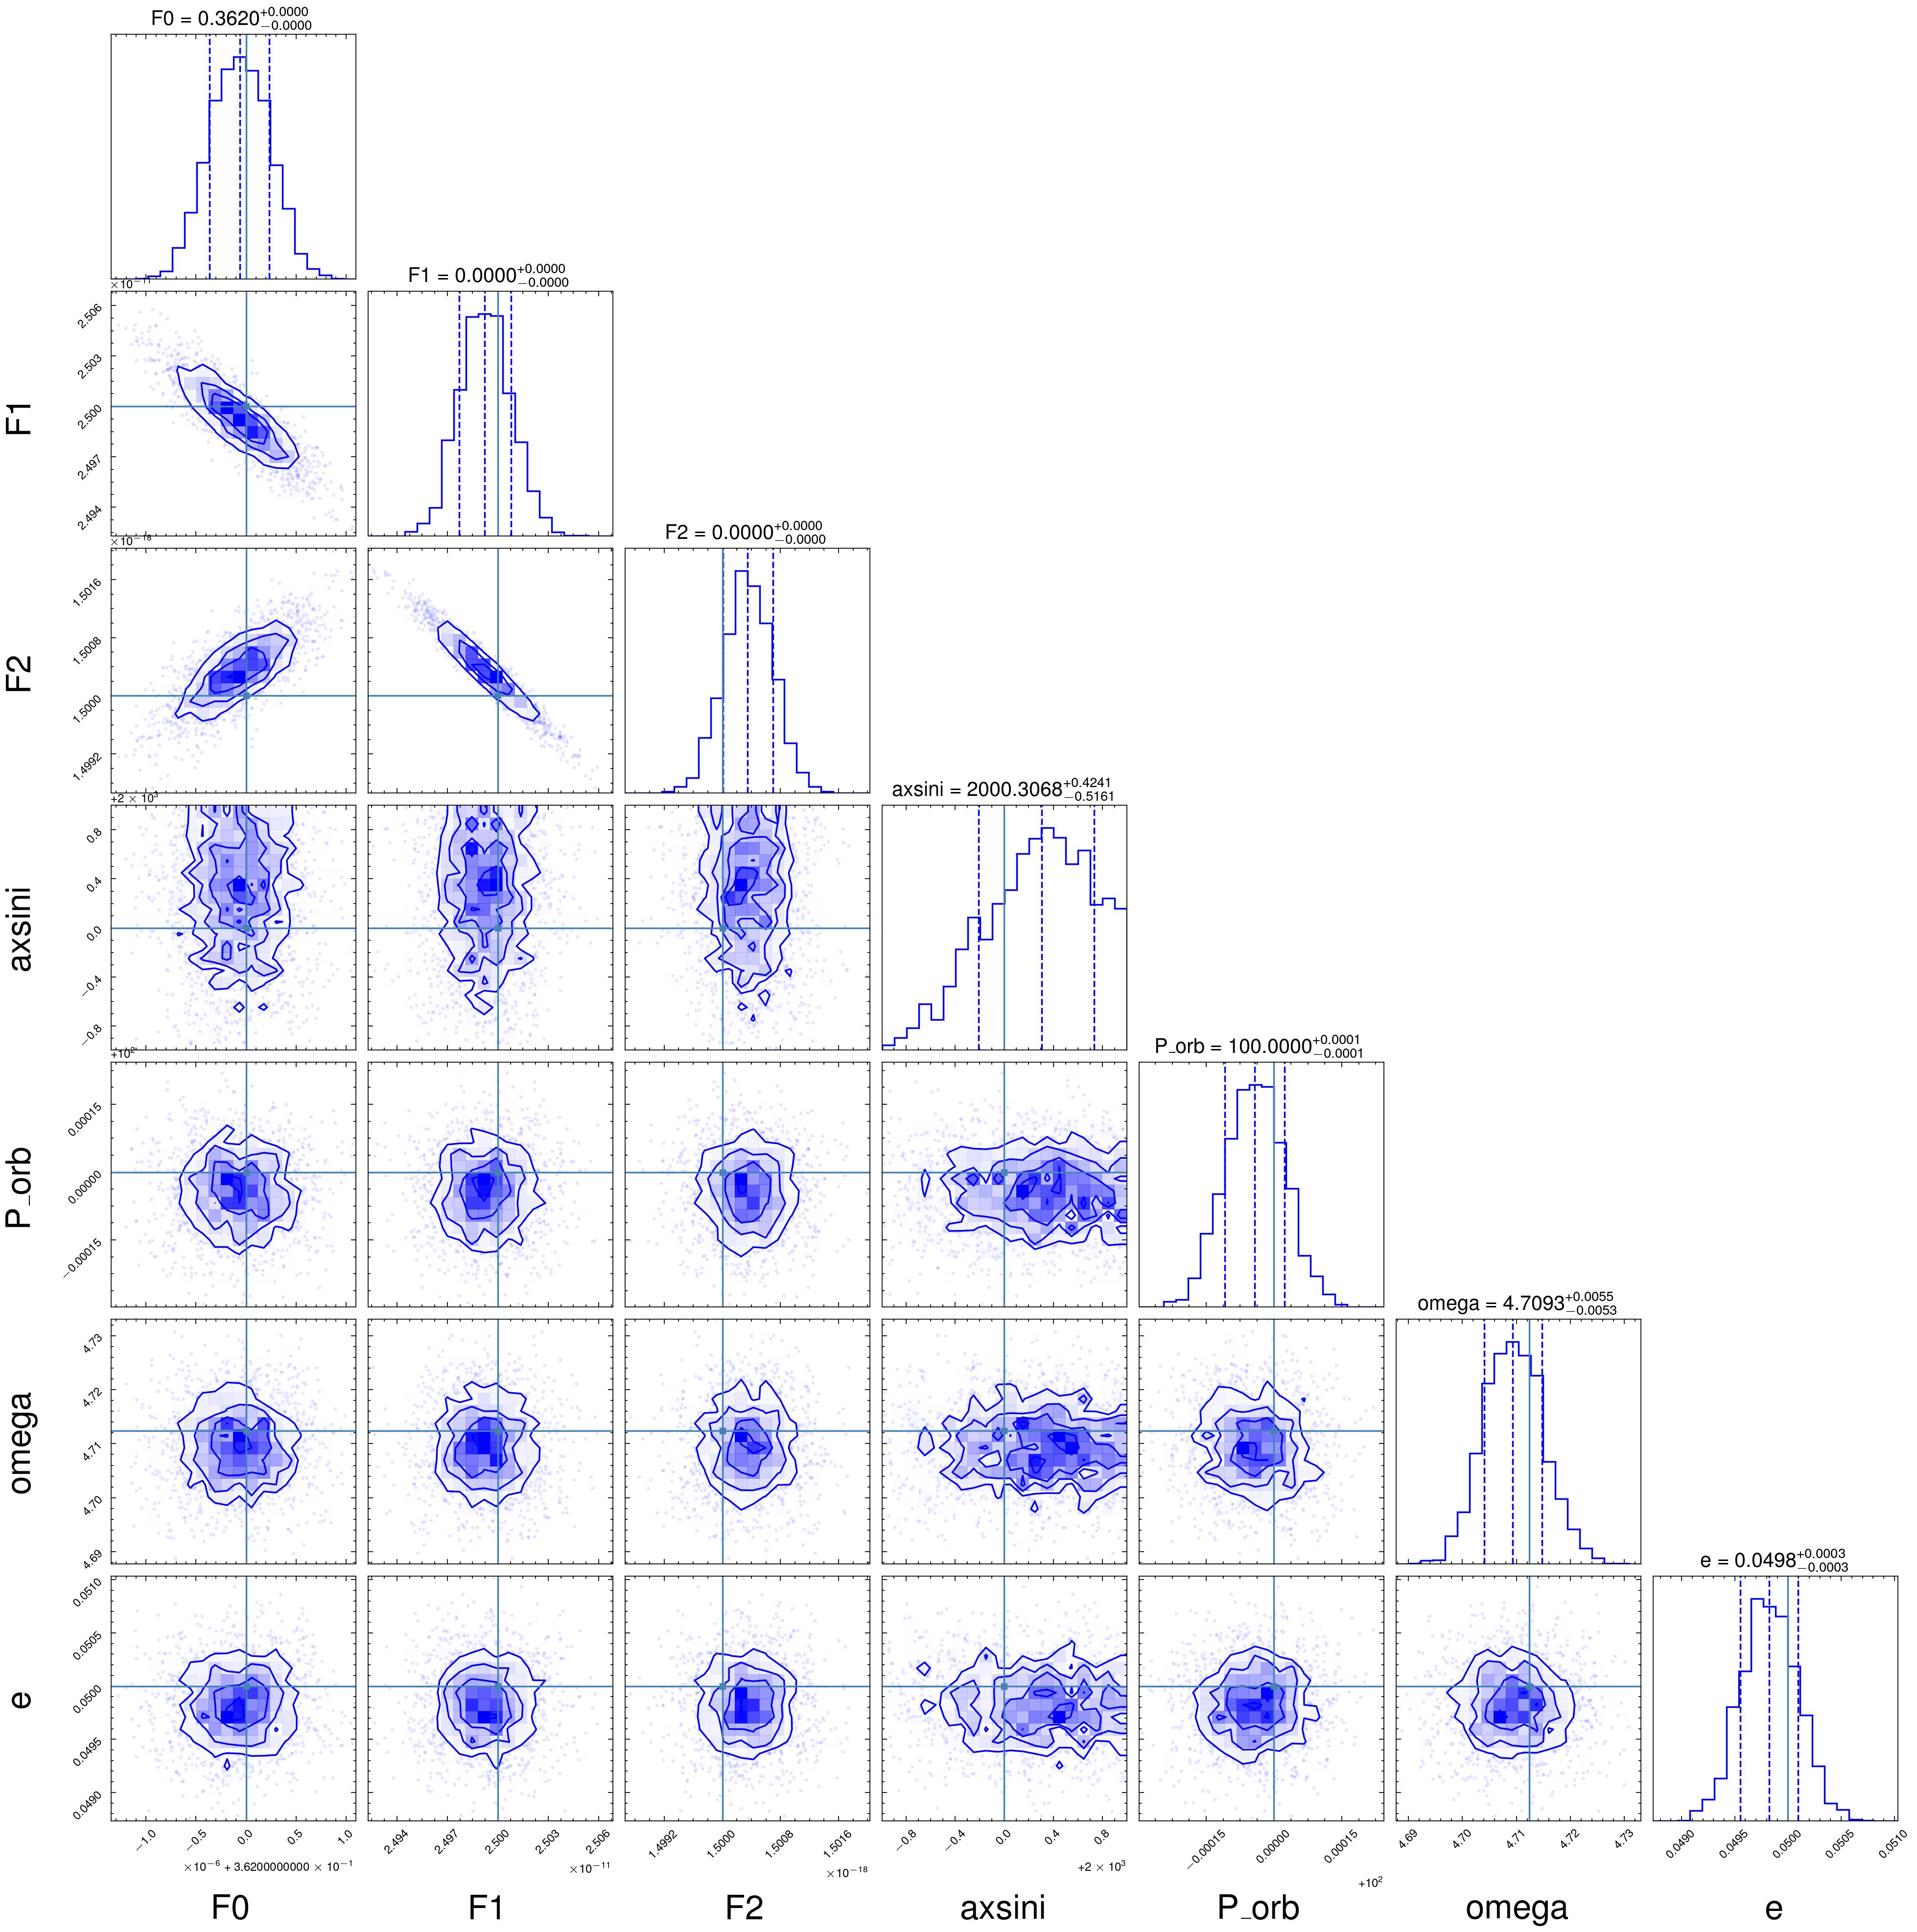

In [24]:
import logging
import corner
def cornerplot(results, logger=None, **kwargs):
    """Make a corner plot with corner."""
    paramnames = results['paramnames']
    data = np.array(results['weighted_samples']['points'])
    weights = np.array(results['weighted_samples']['weights'])
    cumsumweights = np.cumsum(weights)

    mask = cumsumweights > 1e-4

    if mask.sum() == 1:
        print(1)
        if logger is not None:
            print(2)
            warn = 'Posterior is still concentrated in a single point:'
            for i, p in enumerate(paramnames):

                v = results['samples'][mask,i]
                warn += "\n" + '    %-20s: %s' % (p, v)
            logger.warning(warn)
            logger.info('Try running longer.')
        # return

    # monkey patch to disable a useless warning
    oldfunc = logging.warning
    logging.warning = lambda *args, **kwargs: None
    if 'truths' in kwargs:
        truths=kwargs['truths']
    else:
        truths=None
    corner.corner(data[mask,:], weights=weights[mask],
                  labels=paramnames, show_titles=True, quiet=True,
                  fontsize=20, title_fmt='.4f', title_kwargs={'fontsize':12},
                  label_kwargs={'fontsize':20},
                  quantiles=[0.16, 0.5, 0.84],
                  truths=truths,
                  color='b')                                                     
    logging.warning = oldfunc
cornerplot(result, truths=[f0_fake, f1_fake, f2_fake, fake_axsini, fake_Porb, fake_omega, fake_e])